# Segmentación de triángulos

### Alumna: Salma Patricia Gutiérrez Rivera

__1.__ Segmentar las aristas de los triángulos. En los resultados, mostrar la imagen binaria de las aristas.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import math
import skimage
from skimage.measure import label, regionprops
from skimage.color import label2rgb

In [2]:
triangulos = cv.imread("images/triangulos2.jpg", 0)

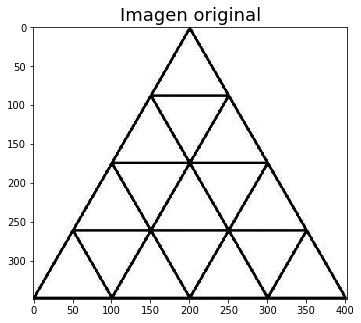

In [3]:
fig = plt.figure(figsize = (10, 5))
fig.add_subplot(1, 1, 1)
plt.imshow(triangulos, cmap = 'gray');
plt.title("Imagen original", size = 18);

In [4]:
bin_triang = np.where(triangulos < 170, 255, 0)

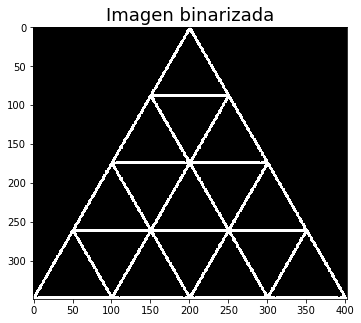

In [5]:
fig = plt.figure(figsize = (10, 5))
fig.add_subplot(1, 1, 1)
plt.imshow(bin_triang, cmap = 'gray');
plt.title("Imagen binarizada", size = 18);

In [6]:
bin_triang = np.where(triangulos < 170, 233, 0)
padd_bin_triang = cv.copyMakeBorder(bin_triang, 10, 10, 10, 10, cv.BORDER_CONSTANT)
imgu8 = np.uint8(padd_bin_triang)
kernel3 = np.ones((3, 3), np.uint8)
contor = cv.erode(imgu8, kernel3, iterations = 1)

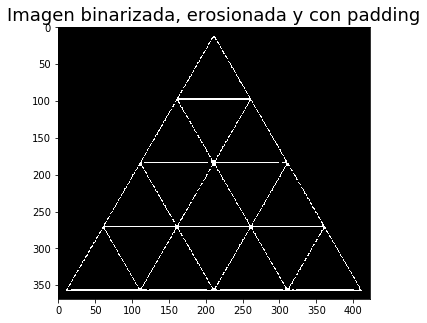

In [7]:
fig = plt.figure(figsize = (10, 5))
fig.add_subplot(1, 1, 1)
plt.imshow(contor, cmap = 'gray');
plt.title("Imagen binarizada, erosionada y con padding", size = 18);

__2.__ Encontrar los modelos de las rectas que forman cada arista. Para esto, solicite un umbral que elimine a las posibles aristas de longitud menor a dicho umbral. Los parámetros que debe encontrar de cada arista son $\theta$, $\rho$ y longitud. Hacer una tabla donde cada renglón sea una arista (identifíquelas con un número) y las columnas sean los parámetros indicados.

In [8]:
img_con_lineasp = cv.cvtColor(contor, cv.COLOR_GRAY2BGR)
lineas_p = cv.HoughLinesP(contor, 1, np.pi / 180, 45, None, 50, 7)
font = cv.FONT_HERSHEY_SIMPLEX 
fontScale = 0.5
color = (255, 0, 0) 
thickness = 1

for i in range(len(lineas_p)):
    l = lineas_p[i][0]
    cv.line(img_con_lineasp, (l[0], l[1]), (l[2], l[3]), (0,0,255), 1, cv.LINE_AA)
    org = ((l[0] + l[2]) // 2, (l[1] + l[3]) // 2)
    img_con_lineasp = cv.putText(img_con_lineasp, str(i), org, font, fontScale, color, thickness, cv.LINE_AA)

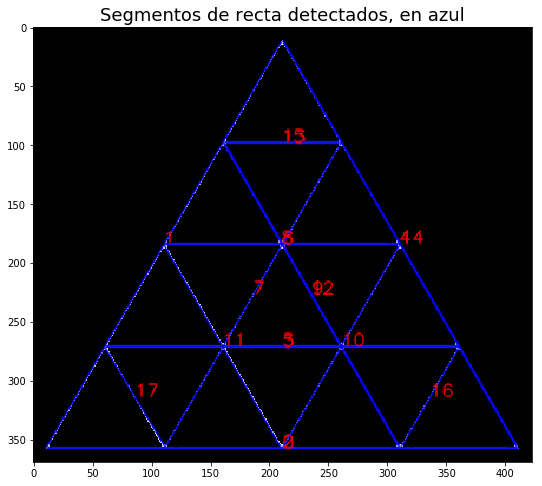

In [9]:
fig = plt.figure(figsize = (20, 8))
fig.add_subplot(1, 1, 1)
plt.imshow(img_con_lineasp);
plt.title("Segmentos de recta detectados, en azul", size = 18);

In [10]:
print("Se detectaron", lineas_p.shape[0], "segmentos de recta")

Se detectaron 18 segmentos de recta


A simple vista, veo que 21, 7 y 17 forman una solo línea. Lo mismo pasa con 19 y 14 y con 10 y 3. Además, 23 y 18 son redundantes. Corregiré a mano.

In [11]:
lineas_p[3][0][2] = lineas_p[10][0][2]
lineas_p[3][0][3] = lineas_p[10][0][3]
lineas_p[7][0][2] = lineas_p[17][0][2]
lineas_p[7][0][3] = lineas_p[17][0][3]
lineas_p[7][0][0] = lineas_p[21][0][0]
lineas_p[7][0][1] = lineas_p[21][0][1]
lineas_p[14][0][0] = lineas_p[19][0][0]
lineas_p[14][0][1] = lineas_p[19][0][1]
lineas_p = np.delete(lineas_p, 23, 0);
lineas_p = np.delete(lineas_p, 21, 0);
lineas_p = np.delete(lineas_p, 19, 0);
lineas_p = np.delete(lineas_p, 18, 0);
lineas_p = np.delete(lineas_p, 17, 0);
lineas_p = np.delete(lineas_p, 10, 0);

In [12]:
def obtener_houghparams(puntos):
    x1 = puntos[0]
    y1 = puntos[1]
    x2 = puntos[2]
    y2 = puntos[3]
    
    theta = math.atan((x1 - x2) / (y2 - y1))
    rho = x1 * math.cos(theta) + y1 * math.sin(theta)
    longitud = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    return [round(theta * 180.0 / math.pi), round(rho), round(longitud)]

In [13]:
img_con_lineasp = cv.cvtColor(contor, cv.COLOR_GRAY2BGR)
hough_params = []

for i in range(len(lineas_p)):
    l = lineas_p[i][0]
    cv.line(img_con_lineasp, (l[0], l[1]), (l[2], l[3]), (0,0,255), 1, cv.LINE_AA)
    params = obtener_houghparams(l)
    hough_params.append(params)
    org = ((l[0] + l[2]) // 2, (l[1] + l[3]) // 2)
    img_con_lineasp = cv.putText(img_con_lineasp, str(i), org, font, fontScale, color, thickness, cv.LINE_AA)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in int_scalars
  import sys


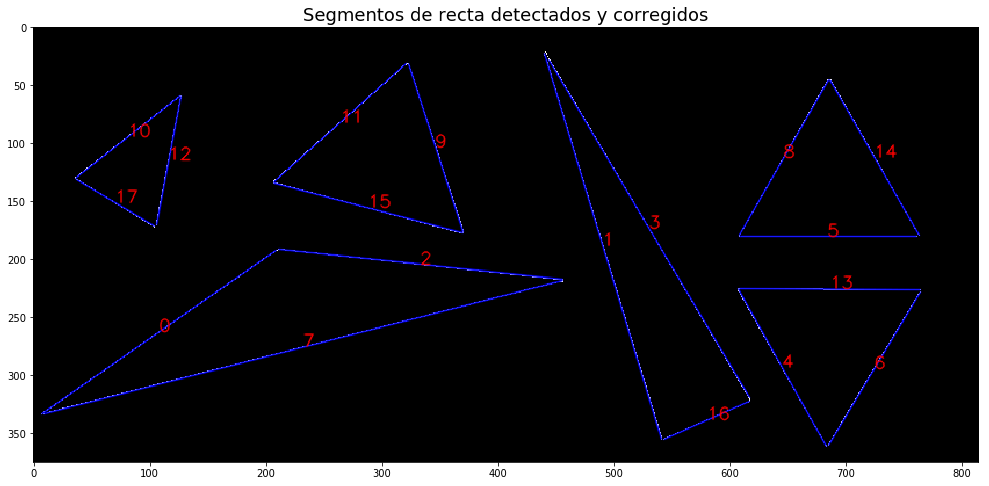

In [43]:
fig = plt.figure(figsize = (20, 8))
fig.add_subplot(1, 1, 1)
plt.imshow(img_con_lineasp);
plt.title("Segmentos de recta detectados y corregidos", size = 18);

In [15]:
print("segmento   theta    rho      longitud")

for i in range(len(hough_params)):
    set_ = hough_params[i]
    print(i, "\t  ", set_[0], "\t   ", set_[1], "\t", set_[2])

segmento   theta    rho      longitud
0 	   55 	    277.0 	 246
1 	   -17 	    415.0 	 348
2 	   -84 	    -168.0 	 246
3 	   -31 	    367.0 	 339
4 	   -29 	    420.0 	 156
5 	   -90 	    -180.0 	 153
6 	   31 	    773.0 	 154
7 	   76 	    325.0 	 462
8 	   30 	    616.0 	 155
9 	   -18 	    298.0 	 152
10 	   52 	    124.0 	 115
11 	   48 	    237.0 	 153
12 	   11 	    136.0 	 113
13 	   -90 	    -221.0 	 156
14 	   -30 	    572.0 	 155
15 	   -75 	    -77.0 	 169
16 	   66 	    545.0 	 81
17 	   -59 	    -94.0 	 78


__3.__ Encontrar las aristas que son paralelas. Reporte cuántos grupos de aristas paralelas encontró y cuáles son paralelas entre ellas.

La rectas paralelas son las que tienen mismo ángulo y distinto radio.

In [16]:
mp = dict()

for i in range(len(hough_params)):
    if hough_params[i][0] in mp.keys():
        mp[hough_params[i][0]][0].append(i)
        mp[hough_params[i][0]][1] += 1
    else: 
        mp[hough_params[i][0]] = [[i], 1]

ans = 0

for it in mp: 
    count = mp[it][1] 
    ans += (count * (count - 1)) // 2
    
print("Hay", ans, "pares de líneas paralelas.")

for trash, notrash in mp.items():
    if len(notrash[0]) > 1:
        print('Las líneas', notrash[0], 'son paralelas entre sí.')

Hay 1 pares de líneas paralelas.
Las líneas [5, 13] son paralelas entre sí.


__4.__ De la lista de aristas obtenidas en el objetivo 2, agrupe aquellas que formen los triángulos observados en la imagen. Haga una tabla donde los renglones identifiquen al triángulo y las columnas (3) sean los números que identifiquen a las aristas que lo forman.

In [35]:
# Etiquetar triángulos
etiquetas = label(padd_bin_triang)
etiquetas_padibujo = label2rgb(etiquetas, image = padd_bin_triang)
letrero = 1

for region in regionprops(etiquetas):
    y0, x0 = region.centroid
    y0 = int(y0)
    x0 = int(x0)
    org = (x0, y0)
    etiquetas_padibujo = cv.putText(etiquetas_padibujo, str(letrero), org, font, 1, color, thickness, cv.LINE_AA)
    letrero += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


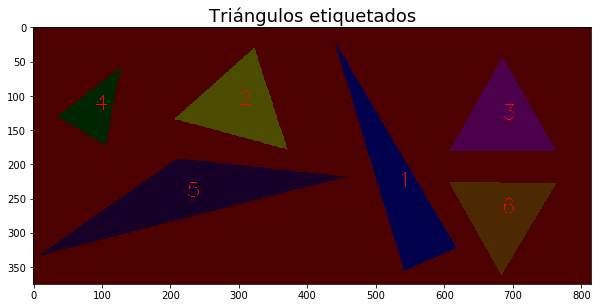

In [36]:
fig = plt.figure(figsize = (10, 5))
fig.add_subplot(1, 1, 1)
plt.imshow(etiquetas_padibujo);
plt.title("Triángulos etiquetados", size = 18);

In [50]:
rectas_triang = []

for i in range(letrero - 1):
    rectas_triang.append([])

for i in range(len(lineas_p)):
    l = lineas_p[i][0]
    x1 = l[0]
    y1 = l[1]
    x2 = l[2]
    y2 = l[3]
    su_etiqueta1 = etiquetas[y1][x1]
    su_etiqueta2 = etiquetas[y2][x2]
    
    # Estos ifs revisan si algún punto de la recta está dentro de algún
    # triángulo. Si no, prueban a moverse un poquito a la izquierda
    # o a la derecha de la línea
    if su_etiqueta1 != 0:
        rectas_triang[su_etiqueta1 - 1].append(i)
    elif su_etiqueta2 != 0:
        rectas_triang[su_etiqueta2 - 1].append(i)
    else:
        xc = (x1 + x2) // 2
        yc = (y1 + y2) // 2
        xmas = xc + 10
        xmenos = xc - 10
        ymas = yc + 10
        ymenos = yc - 10
        su_etiqueta1 = etiquetas[ymas][xmenos]
        su_etiqueta2 = etiquetas[ymenos][xmas]
        
        if su_etiqueta1 != 0:
            rectas_triang[su_etiqueta1 - 1].append(i)
        elif su_etiqueta2 != 0:
            rectas_triang[su_etiqueta2 - 1].append(i)

In [51]:
print(rectas_triang)

[[1, 3, 16], [9, 11, 15], [5, 8, 14], [10, 12, 17], [0, 2, 7], [4, 6, 13]]


In [57]:
print("triángulo   recta1   recta2   recta3")

for i in range(len(rectas_triang)):
    r1 = rectas_triang[i][0]
    r2 = rectas_triang[i][1]
    r3 = rectas_triang[i][2]
    print(i + 1, "\t   ", r1, "\t    ", r2, "      ", r3)

triángulo   recta1   recta2   recta3
1 	    1 	     3        16
2 	    9 	     11        15
3 	    5 	     8        14
4 	    10 	     12        17
5 	    0 	     2        7
6 	    4 	     6        13


Pongo las dos imágenes juntas para comparar.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


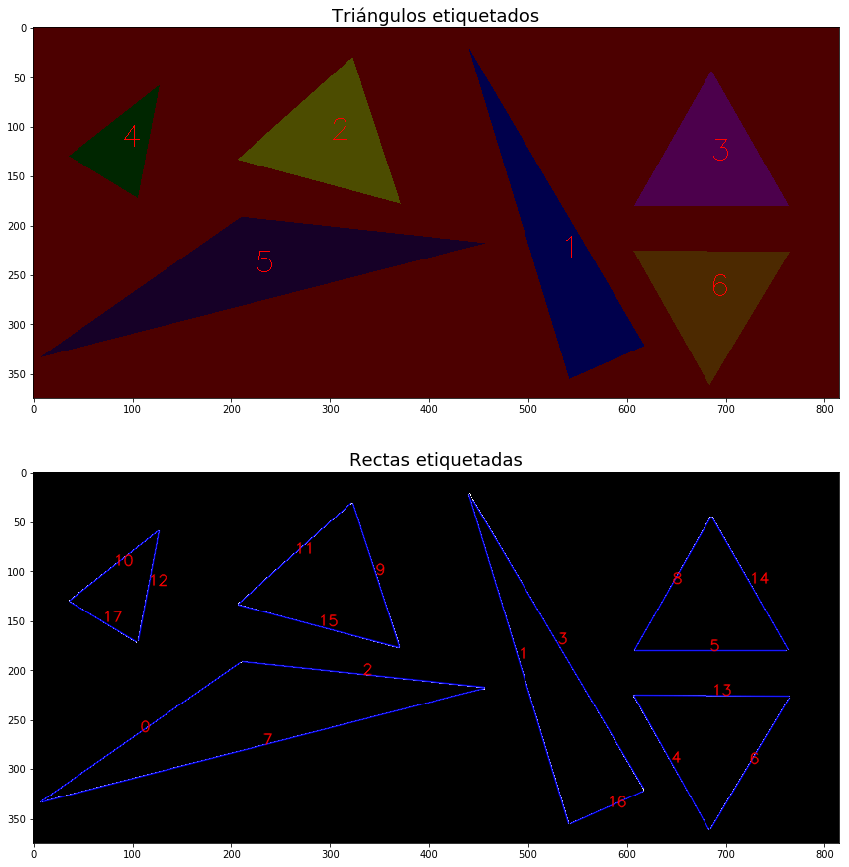

In [60]:
fig = plt.figure(figsize = (25, 15))
fig.add_subplot(2, 1, 1)
plt.imshow(etiquetas_padibujo);
plt.title("Triángulos etiquetados", size = 18);
fig.add_subplot(2, 1, 2)
plt.imshow(img_con_lineasp);
plt.title("Rectas etiquetadas", size = 18);